In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from xgboost import XGBRegressor

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df_original = pd.read_excel('ACB_price.xlsx')
df_ts = df_original
df_ts.columns = ['DATE','CLOSE','OPEN','HIGH','LOW','VOLUME','CHANGE']
df_ts

,DATE,CLOSE,OPEN,HIGH,LOW,VOLUME,CHANGE
0,2025-04-03,24150.0,25150.0,25350.0,24150.0,39.69,-6.94
1,2025-04-02,25950.0,26100.0,26200.0,25900.0,7.48,-0.38
2,2025-04-01,26050.0,26000.0,26050.0,25900.0,3.05,0.19
3,2025-03-31,26000.0,25850.0,26000.0,25800.0,9.13,0.19
4,2025-03-28,25950.0,26000.0,26050.0,25850.0,9.73,-0.19
...,...,...,...,...,...,...,...
4563,2006-12-08,7745.4,7965.1,7965.1,7470.7,550.07K,4.83
4564,2006-12-07,7388.3,6866.5,7388.3,6866.5,274.47K,6.75
4565,2006-12-06,6921.4,6591.8,6921.4,6591.8,927.74K,2.44
4566,2006-12-05,6756.6,6921.4,6921.4,6591.8,1.26,-2.38


In [4]:
X = df_ts[['DATE','CLOSE']]
X.set_index('DATE',inplace = True)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.140680
p-value: 0.228475
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


<Axes: xlabel='DATE'>

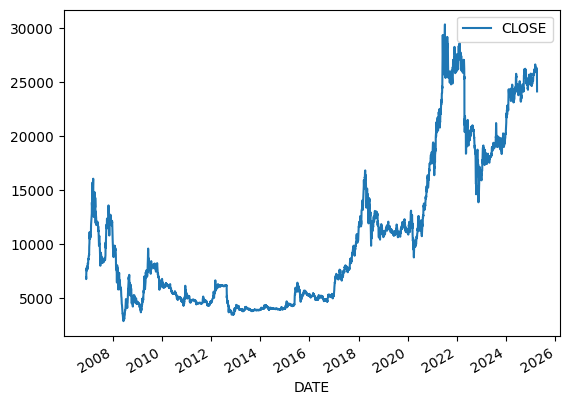

In [5]:
X.plot()

In [6]:
diff_1 = X.diff(1).dropna()
result = adfuller(diff_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -14.638496
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


<Axes: xlabel='DATE'>

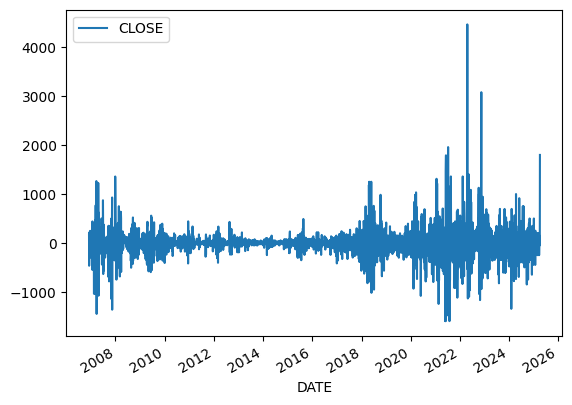

In [7]:
diff_1.plot()

<Figure size 2000x1000 with 0 Axes>

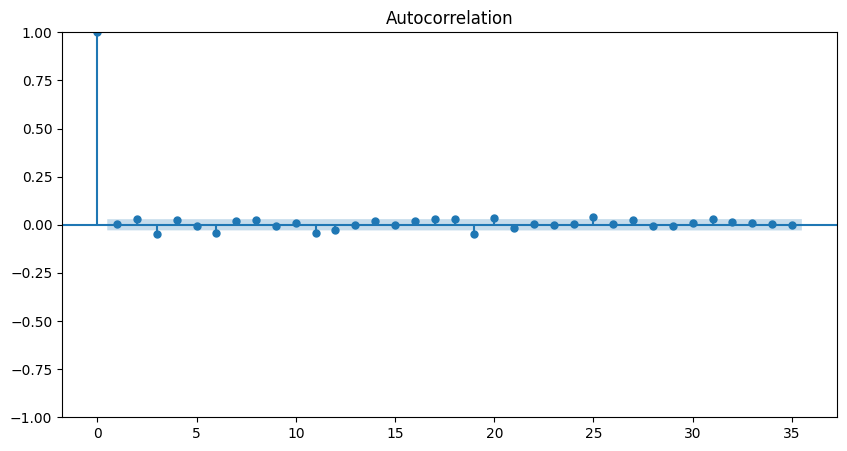

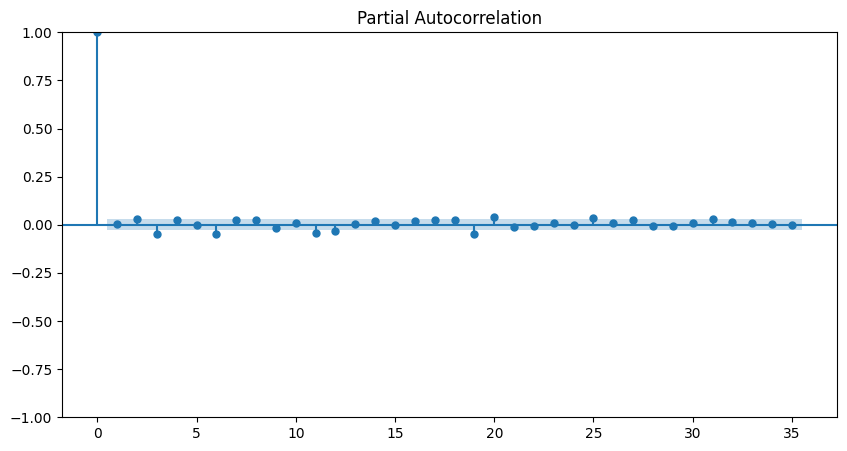

In [8]:
plt.rc("figure", figsize=(10,5))
plt.figure(figsize=(20,10))
plot_acf(diff_1, lags=35)
plot_pacf(diff_1, lags=35)
plt.show()

In [9]:
size = int(len(diff_1) * 0.8)
train, test = diff_1[0:size], diff_1[size:len(diff_1)]
size_test = int(len(test) * 0.8)
valid, oot = test[0:size_test], test[size_test:len(test)]

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [11]:
ACB_recent = diff_1['CLOSE']
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return X, y

# define input sequence
# choose a number of time steps
n_steps = 10
# split into samples
X,y= split_sequence(ACB_recent, n_steps)

In [12]:
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
size_test = int(len(test) * 0.8)
valid, oot = test[0:size_test], test[size_test:len(test)]

size1 = int(len(y) * 0.8)
train1, test1 = y[0:size], y[size:len(y)]
size_test1 = int(len(test1) * 0.8)
valid1, oot1 = test1[0:size_test], test1[size_test:len(test)]

In [13]:
X_train = np.hstack(train).reshape(len(train),n_steps,1)
y_train = np.hstack(train1).reshape(len(train1),1)
X_valid = np.hstack(valid).reshape(len(valid),n_steps,1)
y_valid = np.hstack(valid1).reshape(len(valid1),1)
print(X_train.shape,y_train.shape,X_valid.shape,y_valid.shape)

(3645, 10, 1) (3645, 1) (729, 10, 1) (729, 1)


In [14]:
input_length = X_train.shape[1]
input_dim = X_train.shape[2]
# Output dimensions is the shape of a single output vector
# In this case it's just 1, but it could be more
output_dim = len(y_train[0])
print(input_length,input_dim)

10 1


In [15]:
N_VALIDATION = len(y_valid)
N_TRAIN = len(y_train)
#BUFFER_SIZE = int(1e4)
BATCH_SIZE = 16
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
print(STEPS_PER_EPOCH)

227


In [16]:
import pathlib
import shutil
import tempfile
from tensorflow.keras import layers
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [96]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='loss',mode="min",patience=50),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [123]:
def compile_and_fit(model, name, max_epochs=5000):
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanAbsolutePercentageError()])

  model.summary()

  history = model.fit(
    X_train, y_train,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    callbacks=get_callbacks(name),
    validation_data=(X_valid, y_valid),
    verbose=0,
    batch_size=BATCH_SIZE)
  return history

In [125]:
tiny_model = Sequential()
#tiny_model.add(LSTM(126, activation='silu', input_shape=(n_steps, 1),return_sequences=True))
#tiny_model.add(LSTM(126, activation='silu', input_shape=(n_steps, 1),return_sequences=True))
#tiny_model.add(LSTM(256, activation='silu', input_shape=(n_steps, 1),return_sequences=True))
tiny_model.add(LSTM(64, activation='silu', input_shape=(n_steps, 1)))
tiny_model.add(Dense(1))

In [122]:
tiny_model.get_weights()

[array([[-0.02913721,  0.09483859,  0.06230225, -0.11179002, -0.02253377,
          0.10164042,  0.06745388,  0.13442452, -0.01399408,  0.09391685,
          0.01268685, -0.06531632,  0.04696476,  0.0340824 , -0.10921568,
          0.05469456,  0.05233169, -0.06882904,  0.00721505, -0.08985205,
         -0.0901444 ,  0.02573709,  0.09714769, -0.08955832, -0.04045936,
          0.1019112 , -0.08600958, -0.15191095,  0.0433926 ,  0.07165569,
          0.05529881,  0.13476415, -0.12037579, -0.02907214, -0.0080661 ,
          0.01176946, -0.14588848, -0.12440598, -0.12635851, -0.00996804,
          0.11516868, -0.13929546, -0.02085133, -0.09567708, -0.10481729,
         -0.05751246, -0.03780804, -0.07404711, -0.09439892,  0.12673442,
         -0.10632419,  0.0605344 ,  0.05018908,  0.07193069, -0.08835926,
          0.08462629, -0.06902557,  0.04167084, -0.11057059, -0.08310086,
          0.11399646, -0.04352942, -0.11910714, -0.10419086,  0.06935948,
          0.01718506, -0.05133914, -0.

In [126]:
size_histories = {}
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_38 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, loss:66320.1797,  mean_absolute_percentage_error:689204480.0000,  mean_squared_error:66320.1797,  val_loss:48275.3359,  val_mean_absolute_percentage_error:410741632.0000,  val_mean_squared_error:47901.1133,  
..................................................................

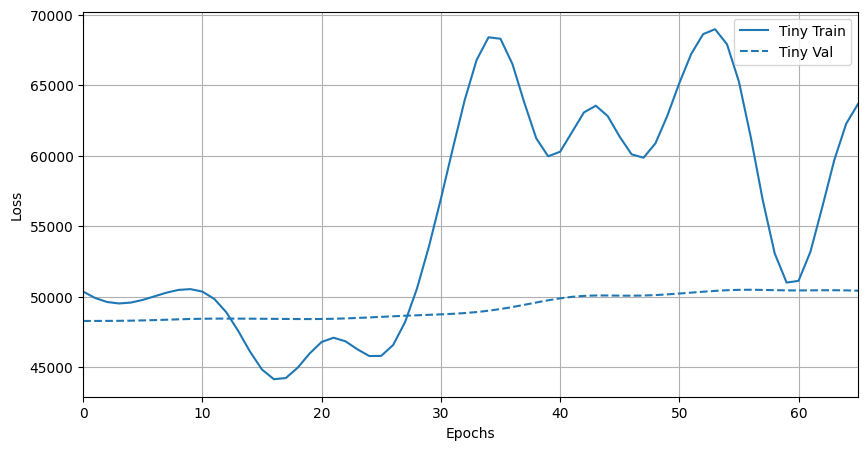

In [127]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(size_histories)

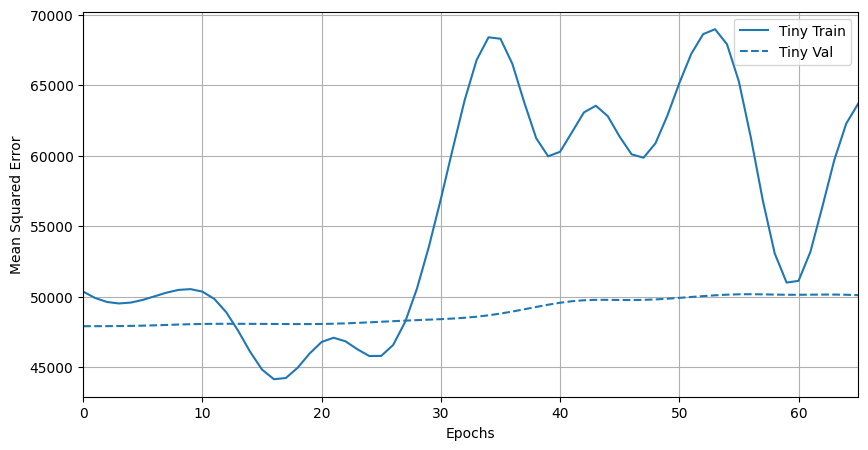

In [128]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_squared_error', smoothing_std=10)
plotter.plot(size_histories)

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


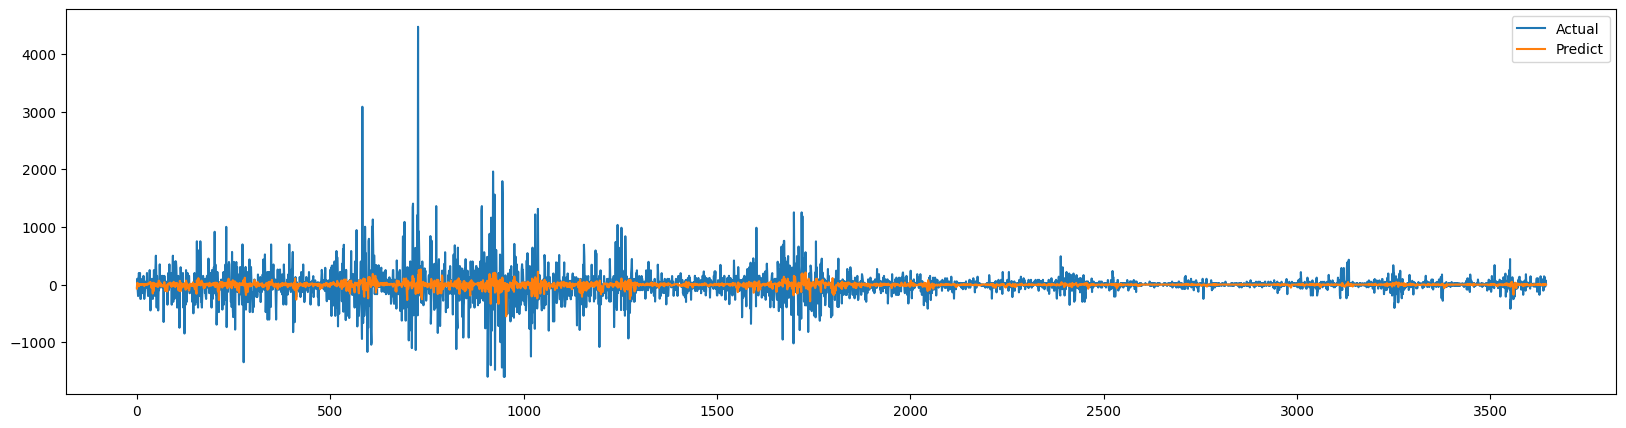

In [129]:
X_train = np.hstack(train).reshape(len(train),n_steps,1)
yhat = pd.DataFrame(tiny_model.predict(X_train))
yhat.columns = ['CLOSE']

df_actual = pd.DataFrame(train1,columns=['actual'])
df_actual

plt.figure(figsize=(20,5))
plt.plot(df_actual,label="Actual")
plt.plot(yhat ,label="Predict")
plt.legend()
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


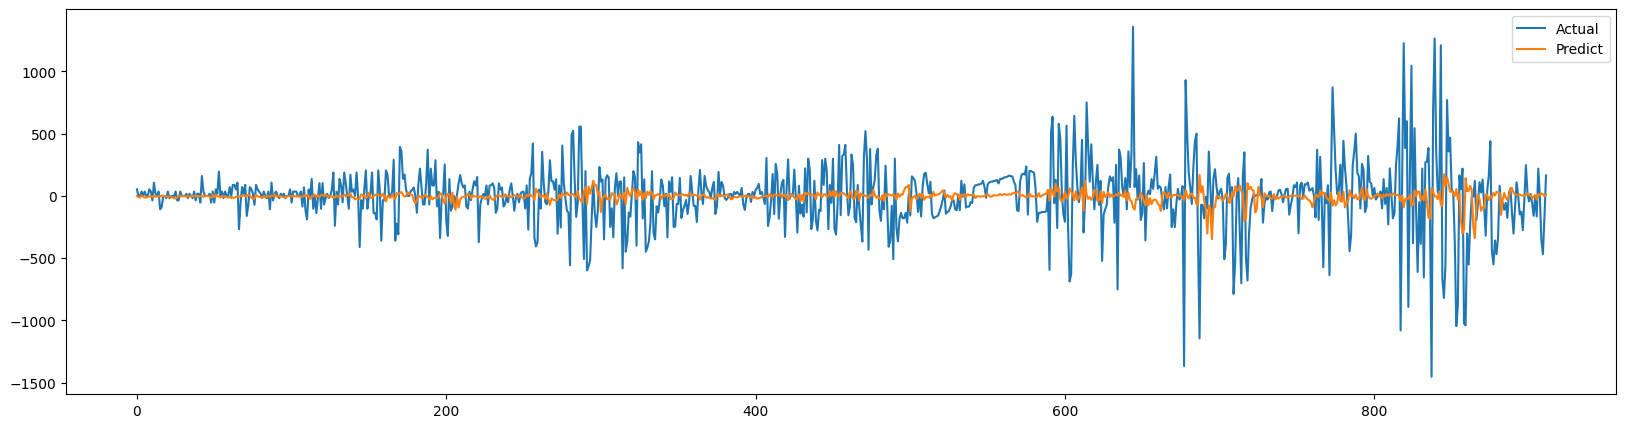

In [130]:
X_test = np.hstack(test).reshape(len(test),n_steps,1)
yhat = pd.DataFrame(tiny_model.predict(X_test))
yhat.columns = ['CLOSE']

df_actual = pd.DataFrame(test1,columns=['actual'])
df_actual

plt.figure(figsize=(20,5))
plt.plot(df_actual,label="Actual")
plt.plot(yhat ,label="Predict")
plt.legend()
plt.show()